In [1]:
import os
import copy
import random
import numpy as np
import torch
import torch.nn as nn

from collections import OrderedDict
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from collections import Counter

In [2]:
# ============================================================
# 0) CONFIG
# ============================================================
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SAVE_NPZ_CACHE = True
CACHE_PATH = r"E:\Duc\Safety Driving (2)\Safety Driving\SAD1\SAD_cache_paper_hp1.0_lp50.0_fs128_t-3.0_0.0_aug1x1_minAfterAug0.npz"

SAD_C = 33
SAD_T = 385

# -------- NEW: Train/Test split (paper-style) --------
TRAIN_RATE = 0.7            # 70% train, 30% test (held-out)
QR_SPLIT_RATE = 0.6         # inside TRAIN: support/query split (e.g., 60/40)

BATCH_SIZE = 64
NUM_ROUNDS = 500

INNER_LR = 1e-3
OUTTER_LR = 1e-3
INNER_STEP = 5
OUTTER_STEP = 1
P_RATE = 0.6

# model
D_MODEL = 64
N_HEAD = 4
N_LAYERS = 5

# hypernet
EMBED_DIM = 16
HIDDEN_DIM = 128
HYPER_LR = 5e-4
EMBED_LR = 5e-4

# hypernet supervision weight (server-side)
LAMBDA_HYPER = 1.0

In [3]:



def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def compute_class_weights(subjects_Y):
    cnt = Counter()
    for y in subjects_Y:
        cnt.update(y.tolist())

    total = cnt[0] + cnt[1]
    w0 = total / (2.0 * max(1, cnt[0]))
    w1 = total / (2.0 * max(1, cnt[1]))

    # temper (sqrt)
    w0 = np.sqrt(w0)
    w1 = np.sqrt(w1)

    print(f"[Class Weight TEMPERED] class0={w0:.3f}, class1={w1:.3f}")
    return torch.tensor([w0, w1], dtype=torch.float32)

def zscore_per_trial(X: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    """
    X: (N, C, T)
    Z-score per trial, per channel (normalize across time axis).
    """
    mu = X.mean(axis=-1, keepdims=True)
    sd = X.std(axis=-1, keepdims=True)
    return (X - mu) / (sd + eps)

In [4]:

# ============================================================
# 1) Train/Test + Support/Query split (paper-grade)
def make_train_support_query_test_sets(subjects_X, subjects_Y,
                                       train_rate=0.7, qr_split_rate=0.6,
                                       do_zscore=True):
    """
    Per subject:
      - split into train/test (70/30)
      - inside train: split into support/query (60/40)
    Returns:
      sup_sets, que_sets, test_sets (TensorDataset lists, aligned per subject)
    """
    sup_sets, que_sets, test_sets = [], [], []

    for X, Y in zip(subjects_X, subjects_Y):
        n = len(X)
        idx = np.arange(n)
        np.random.shuffle(idx)

        n_train = int(n * train_rate)
        tr_idx = idx[:n_train]
        te_idx = idx[n_train:]

        Xtr, Ytr = X[tr_idx], Y[tr_idx]
        Xte, Yte = X[te_idx], Y[te_idx]

        # split train -> support/query
        n_tr = len(Xtr)
        tr2 = np.arange(n_tr)
        np.random.shuffle(tr2)

        n_sup = int(n_tr * qr_split_rate)
        sup_idx = tr2[:n_sup]
        que_idx = tr2[n_sup:]

        Xsup, Ysup = Xtr[sup_idx], Ytr[sup_idx]
        Xque, Yque = Xtr[que_idx], Ytr[que_idx]

        # ✅ normalize (per trial, per channel)
        if do_zscore:
            Xsup = zscore_per_trial(Xsup).astype(np.float32)
            Xque = zscore_per_trial(Xque).astype(np.float32)
            Xte  = zscore_per_trial(Xte ).astype(np.float32)
        else:
            Xsup = Xsup.astype(np.float32)
            Xque = Xque.astype(np.float32)
            Xte  = Xte.astype(np.float32)

        sup_sets.append(TensorDataset(torch.from_numpy(Xsup), torch.from_numpy(Ysup).long()))
        que_sets.append(TensorDataset(torch.from_numpy(Xque), torch.from_numpy(Yque).long()))
        test_sets.append(TensorDataset(torch.from_numpy(Xte ), torch.from_numpy(Yte ).long()))

    return sup_sets, que_sets, test_sets

In [5]:

# ============================================================
# 4) Model: Transformer backbone (global)
# ============================================================
class TemporalAttention(nn.Module):
    """
    Learnable temporal attention pooling
    """
    def __init__(self, d_model):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.Tanh(),
            nn.Linear(d_model // 2, 1)
        )

    def forward(self, x):
        # x: (B, T, D)
        w = self.attn(x)                  # (B, T, 1)
        alpha = torch.softmax(w, dim=1)   # (B, T, 1)
        return (x * alpha).sum(dim=1)     # (B, D)


class EEGTransformer(nn.Module):
    """
    EEG-aware Transformer with spatial + temporal attention
    """
    def __init__(self, C=33, T=600, d_model=64, nhead=4, num_layers=2, num_classes=2):
        super().__init__()
        self.C = C
        self.T = T

        # -------- Spatial modeling (channel correlation) --------
        self.spatial_conv = nn.Conv1d(
            in_channels=C,
            out_channels=C,
            kernel_size=1,
            groups=1,
            bias=False
        )

        # -------- Local temporal modeling --------
        self.temporal_conv = nn.Conv1d(
            in_channels=C,
            out_channels=C,
            kernel_size=7,
            padding=3,
            groups=C,          # depthwise → EEG-friendly
            bias=False
        )

        self.proj = nn.Linear(C, d_model)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=2 * d_model,
            dropout=0.1,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers)

        # -------- Temporal Attention Pooling --------
        self.temp_attn = TemporalAttention(d_model)

        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: (B, C, T)
        # safety check (optional but helpful)
        if x.size(1) != self.C:
            raise RuntimeError(f"[EEGTransformer] Channel mismatch: got {x.size(1)}, expected {self.C}")

        x = self.spatial_conv(x)       # spatial mixing
        x = self.temporal_conv(x)      # local temporal pattern

        x = x.permute(0, 2, 1)         # (B, T, C)
        h = self.proj(x)               # (B, T, D)
        h = self.encoder(h)            # (B, T, D)

        h = self.temp_attn(h)          # (B, D)
        return self.classifier(h)


In [6]:

# ============================================================
# 5) Embed + Constrained Hypernetwork (head-only)
# ============================================================
class Embed(nn.Module):
    def __init__(self, client_num, emb_dim):
        super().__init__()
        self.embed = nn.Embedding(client_num, emb_dim)

    def forward(self, client_id):
        if not torch.is_tensor(client_id):
            client_id = torch.tensor([client_id], dtype=torch.long, device=self.embed.weight.device)
        return self.embed(client_id)  # (1, emb_dim)

class HeadHyperNet(nn.Module):
    def __init__(self, embed: Embed, emb_dim=16, hidden_dim=128, d_model=64, num_classes=2):
        super().__init__()
        self.embed = embed
        self.num_classes = num_classes
        self.d_model = d_model

        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.w_gen = nn.Linear(hidden_dim, num_classes * d_model)
        self.b_gen = nn.Linear(hidden_dim, num_classes)

    def forward(self, client_id):
        e = self.embed(client_id)     # (1, emb_dim)
        h = self.mlp(e)               # (1, hidden_dim)

        w = self.w_gen(h).view(self.num_classes, self.d_model)
        w = w / (w.norm(p=2, dim=1, keepdim=True) + 1e-6)

        b = self.b_gen(h).view(self.num_classes)
        b = torch.clamp(b, -1.0, 1.0)

        return OrderedDict({
            "classifier.weight": w,
            "classifier.bias": b
        })

In [7]:

# ============================================================
# 6) Client: meta-train with support/query (inner/outer)
# ============================================================
class MetaClient:
    def __init__(self, cid, innerlr, outterlr,
                 inner_step, outter_step,
                 batch_size, class_weights):
        self.cid = cid
        self.innerlr = innerlr
        self.outterlr = outterlr
        self.inner_step = inner_step
        self.outter_step = outter_step
        self.batch_size = batch_size

        self.criterion = nn.CrossEntropyLoss(weight=class_weights)

        self.sup_loader = None
        self.que_loader = None
        self.test_loader = None

        # eval loaders (no shuffle / no drop_last)
        self.que_eval_loader = None
        self.test_eval_loader = None

    def init_dataset(self, sup_set, que_set, test_set):
        # train-time loaders
        self.sup_loader = DataLoader(sup_set, batch_size=self.batch_size, shuffle=True, drop_last=True)
        self.que_loader = DataLoader(que_set, batch_size=self.batch_size, shuffle=True, drop_last=False)
        self.test_loader = DataLoader(test_set, batch_size=self.batch_size, shuffle=False, drop_last=False)

        # eval loaders (full)
        self.que_eval_loader = DataLoader(que_set, batch_size=self.batch_size, shuffle=False, drop_last=False)
        self.test_eval_loader = self.test_loader

    @staticmethod
    def _next_batch(loader, it_state):
        try:
            batch = next(it_state["it"])
        except StopIteration:
            it_state["it"] = iter(loader)
            batch = next(it_state["it"])
        return batch

    def train(self, hyper_head, global_state, p_rate, model_ctor):
        """
        Returns:
          outer_state (for FedAvg global update),
          ft_head_target (for hypernet supervision),
          inner_acc/loss, outer_acc/loss
        """

        # (1) mix global head with hyper head
        theta = copy.deepcopy(global_state)
        gw = theta["classifier.weight"]
        gb = theta["classifier.bias"]
        theta["classifier.weight"] = (1 - p_rate) * gw + p_rate * hyper_head["classifier.weight"]
        theta["classifier.bias"]   = (1 - p_rate) * gb + p_rate * hyper_head["classifier.bias"]

        # ---------------- INNER: support fine-tune ----------------
        fast_model = model_ctor().to(DEVICE)
        fast_model.load_state_dict(theta, strict=True)
        inner_opt = torch.optim.Adam(fast_model.parameters(), lr=self.innerlr)

        sup_it = {"it": iter(self.sup_loader)}
        total_loss, total_correct, total_sample = 0, 0, 0

        for _ in range(self.inner_step):
            xb, yb = self._next_batch(self.sup_loader, sup_it)
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            inner_opt.zero_grad()
            logits = fast_model(xb)
            loss = self.criterion(logits, yb)
            loss.backward()
            inner_opt.step()

            total_loss += loss.item() * xb.size(0)
            total_correct += (logits.argmax(1) == yb).sum().item()
            total_sample += xb.size(0)

        inner_acc  = total_correct / max(1, total_sample)
        inner_loss = total_loss / max(1, total_sample)

        fast_state = copy.deepcopy(fast_model.state_dict())

        # target head for hypernet supervision (detach)
        ft_head_target = {
            "classifier.weight": fast_state["classifier.weight"].detach().clone(),
            "classifier.bias":   fast_state["classifier.bias"].detach().clone()
        }

        # ---------------- OUTER: query step from fast weights ----------------
        # IMPORTANT: start from fast_model (after inner), not from theta
        outer_model = model_ctor().to(DEVICE)
        outer_model.load_state_dict(fast_state, strict=True)
        out_opt = torch.optim.Adam(outer_model.parameters(), lr=self.outterlr)

        que_it = {"it": iter(self.que_loader)}
        total_loss, total_correct, total_sample = 0, 0, 0

        for _ in range(self.outter_step):
            xb, yb = self._next_batch(self.que_loader, que_it)
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            out_opt.zero_grad()
            logits = outer_model(xb)
            loss = self.criterion(logits, yb)
            loss.backward()
            out_opt.step()

            total_loss += loss.item() * xb.size(0)
            total_correct += (logits.argmax(1) == yb).sum().item()
            total_sample += xb.size(0)

        out_acc  = total_correct / max(1, total_sample)
        out_loss = total_loss / max(1, total_sample)

        outer_state = copy.deepcopy(outer_model.state_dict())
        return outer_state, ft_head_target, inner_acc, inner_loss, out_acc, out_loss

In [8]:
@torch.no_grad()
def eval_query_per_subject_pfml(trainer, p_rate=None, save_txt=False, tag="VAL",
                                print_per_subject=True, print_cm_per_subject=False):
    """
    Evaluate on QUERY split (per subject), using personalized head mixing.
    Reports mean±std over subjects + overall confusion matrix (all query samples).
    Optionally prints per-subject results + per-subject confusion matrices.
    """
    if p_rate is None:
        p_rate = trainer.p_rate

    global_state = copy.deepcopy(trainer.global_model.state_dict())

    per_sub = []
    y_true_all, y_pred_all = [], []

    for c in trainer.clients:
        cid = c.cid
        zeta = trainer.hypernet(torch.tensor([cid], dtype=torch.long, device=DEVICE))

        # personalized theta = mix(global head, zeta head)
        theta = copy.deepcopy(global_state)
        theta["classifier.weight"] = (1.0 - p_rate) * theta["classifier.weight"] + p_rate * zeta["classifier.weight"]
        theta["classifier.bias"]   = (1.0 - p_rate) * theta["classifier.bias"]   + p_rate * zeta["classifier.bias"]

        model = trainer.model_ctor().to(DEVICE)
        model.load_state_dict(theta, strict=True)
        model.eval()

        ys, ps = [], []
        # ✅ QUERY loader (shuffle=False, drop_last=False) để không mất sample
        for xb, yb in c.que_eval_loader:
            xb = xb.to(DEVICE)
            logits = model(xb)
            pred = logits.argmax(1).cpu().numpy()

            ys.append(yb.numpy())
            ps.append(pred)

        ys = np.concatenate(ys) if len(ys) else np.array([], dtype=np.int64)
        ps = np.concatenate(ps) if len(ps) else np.array([], dtype=np.int64)
        if len(ys) == 0:
            continue

        acc_i = accuracy_score(ys, ps)
        f1_i  = f1_score(ys, ps, average="macro")
        cm_i  = confusion_matrix(ys, ps, labels=[0, 1])

        per_sub.append({
            "cid": cid,
            "n": len(ys),
            "acc": acc_i,
            "macro_f1": f1_i,
            "cm": cm_i
        })

        y_true_all.append(ys)
        y_pred_all.append(ps)

    # -------- macro over subjects --------
    acc_list = np.array([d["acc"] for d in per_sub], dtype=np.float32)
    f1_list  = np.array([d["macro_f1"] for d in per_sub], dtype=np.float32)

    acc_mean = acc_list.mean() if len(acc_list) else 0.0
    acc_std  = acc_list.std(ddof=1) if len(acc_list) > 1 else 0.0
    f1_mean  = f1_list.mean() if len(f1_list) else 0.0
    f1_std   = f1_list.std(ddof=1) if len(f1_list) > 1 else 0.0

    # -------- overall confusion matrix (all query samples) --------
    y_true_all = np.concatenate(y_true_all) if len(y_true_all) else np.array([], dtype=np.int64)
    y_pred_all = np.concatenate(y_pred_all) if len(y_pred_all) else np.array([], dtype=np.int64)
    cm = confusion_matrix(y_true_all, y_pred_all, labels=[0, 1]) if len(y_true_all) else np.zeros((2,2), dtype=int)

    print(f"\n================ PFML {tag} (QUERY) ================")
    print(f"Subjects used : {len(per_sub)}")
    print(f"Mean ACC      : {acc_mean*100:.2f}%  (Std {acc_std*100:.2f}%)")
    print(f"Mean Macro-F1 : {f1_mean*100:.2f}%  (Std {f1_std*100:.2f}%)")
    print("Overall Confusion Matrix (all query samples):")
    print(cm)

    if print_per_subject:
        print("\nPer-subject results:")
        print("  cid |     N |   ACC   | Macro-F1")
        print("------|-------|---------|---------")
        for d in per_sub:
            print(f"  {d['cid']:>3} | {d['n']:>5} | {d['acc']*100:>6.2f}% | {d['macro_f1']*100:>7.2f}%")

        if print_cm_per_subject:
            print("\nPer-subject Confusion Matrices:")
            for d in per_sub:
                print(f"[cid={d['cid']}] cm=\n{d['cm']}\n")

    print("====================================================\n")

    if save_txt:
        with open(f"PFML_{tag.lower()}_query_detail.txt", "w") as f:
            f.write(f"Subjects used : {len(per_sub)}\n")
            f.write(f"Mean ACC      : {acc_mean*100:.2f}% (Std {acc_std*100:.2f}%)\n")
            f.write(f"Mean Macro-F1 : {f1_mean*100:.2f}% (Std {f1_std*100:.2f}%)\n")
            f.write("Overall Confusion Matrix:\n")
            f.write(str(cm) + "\n\n")
            f.write("Per-subject:\n")
            for d in per_sub:
                f.write(f"cid={d['cid']} N={d['n']} ACC={d['acc']*100:.2f} Macro-F1={d['macro_f1']*100:.2f}\n")
                if print_cm_per_subject:
                    f.write(f"cm=\n{d['cm']}\n\n")

    return per_sub, (acc_mean, acc_std), (f1_mean, f1_std), cm

In [9]:

# ============================================================
# 7) Evaluation (held-out TEST) - paper-grade
# ============================================================
@torch.no_grad()
def eval_test_per_subject_pfml(trainer, p_rate=None, save_txt=False, tag="TEST",
                               print_per_subject=True, print_cm_per_subject=False):
    """
    Evaluate on held-out TEST split (per subject), using personalized head mixing.
    Reports mean±std over subjects + overall confusion matrix.
    Also optionally prints per-subject results.
    """
    if p_rate is None:
        p_rate = trainer.p_rate

    global_state = copy.deepcopy(trainer.global_model.state_dict())

    per_sub = []
    y_true_all, y_pred_all = [], []

    for c in trainer.clients:
        cid = c.cid
        zeta = trainer.hypernet(torch.tensor([cid], dtype=torch.long, device=DEVICE))

        theta = copy.deepcopy(global_state)
        theta["classifier.weight"] = (1.0 - p_rate) * theta["classifier.weight"] + p_rate * zeta["classifier.weight"]
        theta["classifier.bias"]   = (1.0 - p_rate) * theta["classifier.bias"]   + p_rate * zeta["classifier.bias"]

        model = trainer.model_ctor().to(DEVICE)
        model.load_state_dict(theta, strict=True)
        model.eval()

        ys, ps = [], []
        for xb, yb in c.test_eval_loader:  # <-- TEST loader (shuffle=False, drop_last=False)
            xb = xb.to(DEVICE)
            logits = model(xb)
            pred = logits.argmax(1).cpu().numpy()
            ys.append(yb.numpy())
            ps.append(pred)

        ys = np.concatenate(ys) if len(ys) else np.array([], dtype=np.int64)
        ps = np.concatenate(ps) if len(ps) else np.array([], dtype=np.int64)
        if len(ys) == 0:
            continue

        acc_i = accuracy_score(ys, ps)
        f1_i  = f1_score(ys, ps, average="macro")
        cm_i  = confusion_matrix(ys, ps, labels=[0, 1])

        per_sub.append({
            "cid": cid,
            "n": len(ys),
            "acc": acc_i,
            "macro_f1": f1_i,
            "cm": cm_i
        })

        y_true_all.append(ys)
        y_pred_all.append(ps)

    # macro over subjects
    acc_list = np.array([d["acc"] for d in per_sub], dtype=np.float32)
    f1_list  = np.array([d["macro_f1"] for d in per_sub], dtype=np.float32)

    acc_mean = acc_list.mean() if len(acc_list) else 0.0
    acc_std  = acc_list.std(ddof=1) if len(acc_list) > 1 else 0.0
    f1_mean  = f1_list.mean() if len(f1_list) else 0.0
    f1_std   = f1_list.std(ddof=1) if len(f1_list) > 1 else 0.0

    y_true_all = np.concatenate(y_true_all) if len(y_true_all) else np.array([], dtype=np.int64)
    y_pred_all = np.concatenate(y_pred_all) if len(y_pred_all) else np.array([], dtype=np.int64)
    cm = confusion_matrix(y_true_all, y_pred_all, labels=[0, 1]) if len(y_true_all) else np.zeros((2,2), dtype=int)

    print(f"\n================ PFML {tag} (TEST) ================")
    print(f"Subjects used : {len(per_sub)}")
    print(f"Mean ACC      : {acc_mean*100:.2f}%  (Std {acc_std*100:.2f}%)")
    print(f"Mean Macro-F1 : {f1_mean*100:.2f}%  (Std {f1_std*100:.2f}%)")
    print("Overall Confusion Matrix (all test samples):")
    print(cm)

    if print_per_subject:
        print("\nPer-subject results:")
        print("  cid |     N |   ACC   | Macro-F1")
        print("------|-------|---------|---------")
        for d in per_sub:
            print(f"  {d['cid']:>3} | {d['n']:>5} | {d['acc']*100:>6.2f}% | {d['macro_f1']*100:>7.2f}%")

        if print_cm_per_subject:
            print("\nPer-subject Confusion Matrices:")
            for d in per_sub:
                print(f"[cid={d['cid']}] cm=\n{d['cm']}\n")

    print("====================================================\n")

    if save_txt:
        with open(f"PFML_{tag.lower()}_detail.txt", "w") as f:
            f.write(f"Subjects used : {len(per_sub)}\n")
            f.write(f"Mean ACC      : {acc_mean*100:.2f}% (Std {acc_std*100:.2f}%)\n")
            f.write(f"Mean Macro-F1 : {f1_mean*100:.2f}% (Std {f1_std*100:.2f}%)\n")
            f.write("Overall Confusion Matrix:\n")
            f.write(str(cm) + "\n\n")
            f.write("Per-subject:\n")
            for d in per_sub:
                f.write(f"cid={d['cid']} N={d['n']} ACC={d['acc']*100:.2f} Macro-F1={d['macro_f1']*100:.2f}\n")
                if print_cm_per_subject:
                    f.write(f"cm=\n{d['cm']}\n\n")

    return per_sub, (acc_mean, acc_std), (f1_mean, f1_std), cm

In [10]:
# ============================================================
# 8) Trainer
# ============================================================
class PFMLTrainer:
    def __init__(self, num_client, batch_size, qr_split_rate,
                 innerlr, outterlr, innerstep, outterstep, p_rate):

        self.num_client = num_client
        self.batch_size = batch_size
        self.qr_split_rate = qr_split_rate
        self.innerlr = innerlr
        self.outterlr = outterlr
        self.innerstep = innerstep
        self.outterstep = outterstep
        self.p_rate = p_rate

        self.model_ctor = lambda: EEGTransformer(
            C=SAD_C, T=SAD_T,
            d_model=D_MODEL, nhead=N_HEAD,
            num_layers=N_LAYERS, num_classes=2
        )

        self.global_model = self.model_ctor().to(DEVICE)

        self.embed = Embed(self.num_client, EMBED_DIM).to(DEVICE)
        self.hypernet = HeadHyperNet(
            self.embed, EMBED_DIM, HIDDEN_DIM, D_MODEL, 2
        ).to(DEVICE)

        # optimize hypernet (excluding embedding) + embedding separately
        self.hyper_opt = torch.optim.Adam(
            [p for n, p in self.hypernet.named_parameters() if "embed" not in n],
            lr=HYPER_LR
        )
        self.embed_opt = torch.optim.Adam(self.embed.parameters(), lr=EMBED_LR)

        self.clients = []
        self.class_weights = None

        # =========================
        # [ADD] history for plotting
        # =========================
        self.history = {
            "round": [],
            "p_rate": [],
            "val_acc_mean": [],
            "val_acc_std": [],
            "val_f1_mean": [],
            "val_f1_std": [],
            "hyper_loss": [],
            # optional train dynamics
            "inner_acc_mean": [],
            "inner_loss_mean": [],
            "outer_acc_mean": [],
            "outer_loss_mean": [],
        }

    def init_clients(self, sup_sets, que_sets, test_sets):
        self.clients = []
        for cid in range(self.num_client):
            c = MetaClient(
                cid,
                self.innerlr,
                self.outterlr,
                self.innerstep,
                self.outterstep,
                self.batch_size,
                self.class_weights
            )
            c.init_dataset(sup_sets[cid], que_sets[cid], test_sets[cid])
            self.clients.append(c)
        print(f"[PFML] Created {len(self.clients)} clients.")

    def fedavg(self, model_states):
        avg = OrderedDict()
        for k in model_states[0].keys():
            avg[k] = sum(ms[k] for ms in model_states) / len(model_states)
        return avg

    def run(self, num_rounds):
        print(f"[PFML] Start training on {DEVICE}, rounds={num_rounds}")

        best_val_acc = 0.0
        best_round = 0
        best_p_rate = None

        mse = nn.MSELoss()

        for rnd in range(1, num_rounds + 1):
            # schedule p_rate
            p_rate_rnd = min(
                self.p_rate,
                0.10 + (self.p_rate - 0.10) * rnd / num_rounds
            )

            outer_states = []
            global_state = copy.deepcopy(self.global_model.state_dict())

            hyper_loss_total = 0.0

            # =========================
            # [ADD] collect inner/outer stats over clients
            # =========================
            inner_acc_list, inner_loss_list = [], []
            outer_acc_list, outer_loss_list = [], []

            for c in self.clients:
                cid_t = torch.tensor([c.cid], dtype=torch.long, device=DEVICE)

                # zeta_i from hypernet
                zeta = self.hypernet(cid_t)

                # client meta-learning
                outer_state, ft_head_target, inner_acc, inner_loss, out_acc, out_loss = c.train(
                    zeta, global_state, p_rate_rnd, self.model_ctor
                )
                outer_states.append(outer_state)

                # =========================
                # [ADD] store per-client stats
                # =========================
                inner_acc_list.append(inner_acc)
                inner_loss_list.append(inner_loss)
                outer_acc_list.append(out_acc)
                outer_loss_list.append(out_loss)

                # hypernet supervision
                hyper_loss = mse(zeta["classifier.weight"], ft_head_target["classifier.weight"]) + \
                             mse(zeta["classifier.bias"],   ft_head_target["classifier.bias"])
                hyper_loss_total = hyper_loss_total + hyper_loss

            # (1) update global model by FedAvg
            self.global_model.load_state_dict(self.fedavg(outer_states), strict=True)

            # (2) update hypernet + embed on server
            self.hyper_opt.zero_grad()
            self.embed_opt.zero_grad()
            (LAMBDA_HYPER * hyper_loss_total / max(1, len(self.clients))).backward()
            self.hyper_opt.step()
            self.embed_opt.step()

            # (3) VAL = QUERY (paper-grade model selection)
            _, acc_stat, f1_stat, _ = eval_query_per_subject_pfml(
                self,
                p_rate=p_rate_rnd,
                save_txt=False,
                tag=f"VAL@Round{rnd:03d}",
                print_per_subject=True
            )
            val_acc_mean, val_acc_std = acc_stat
            val_f1_mean,  val_f1_std  = f1_stat

            print(
                f"[ROUND {rnd:03d}] "
                f"p_rate={p_rate_rnd:.3f} | "
                f"VAL(QUERY) ACC = {val_acc_mean*100:.2f}% ± {val_acc_std*100:.2f}% | "
                f"Macro-F1 = {val_f1_mean*100:.2f}% ± {val_f1_std*100:.2f}% | "
                f"HyperLoss={(hyper_loss_total.item()/max(1,len(self.clients))):.6f}"
            )

            # =========================
            # [ADD] write history (for plotting)
            # =========================
            self.history["round"].append(int(rnd))
            self.history["p_rate"].append(float(p_rate_rnd))
            self.history["val_acc_mean"].append(float(val_acc_mean))
            self.history["val_acc_std"].append(float(val_acc_std))
            self.history["val_f1_mean"].append(float(val_f1_mean))
            self.history["val_f1_std"].append(float(val_f1_std))
            self.history["hyper_loss"].append(float(hyper_loss_total.item() / max(1, len(self.clients))))

            self.history["inner_acc_mean"].append(float(np.mean(inner_acc_list)) if len(inner_acc_list) else 0.0)
            self.history["inner_loss_mean"].append(float(np.mean(inner_loss_list)) if len(inner_loss_list) else 0.0)
            self.history["outer_acc_mean"].append(float(np.mean(outer_acc_list)) if len(outer_acc_list) else 0.0)
            self.history["outer_loss_mean"].append(float(np.mean(outer_loss_list)) if len(outer_loss_list) else 0.0)

            # ✅ select best by VAL/QUERY
            if val_acc_mean > best_val_acc:
                best_val_acc = val_acc_mean
                best_round = rnd
                best_p_rate = p_rate_rnd

                torch.save(self.global_model.state_dict(), "PFML_bestVAL_global.pth")
                torch.save(self.hypernet.state_dict(), "PFML_bestVAL_hypernet.pth")
                torch.save(self.embed.state_dict(), "PFML_bestVAL_embed.pth")

                # save meta for final test p_rate
                meta = {
                    "best_round": int(best_round),
                    "best_val_acc": float(best_val_acc),
                    "best_p_rate": float(best_p_rate)
                }
                with open("PFML_bestVAL_meta.json", "w") as f:
                    import json
                    json.dump(meta, f, indent=2)

                print(f"🔥 NEW BEST (by VAL/QUERY) @ Round {rnd} | Acc={best_val_acc*100:.2f}%")

        print("\n================ BEST ROUND SUMMARY ================")
        print(f"Best VAL(QUERY) Accuracy : {best_val_acc*100:.2f}%")
        print(f"Best Round               : {best_round}")
        # print(f"Best p_rate              : {best_p_rate}")
        print("Saved checkpoints:")
        print(" - PFML_bestVAL_global.pth")
        print(" - PFML_bestVAL_hypernet.pth")
        print(" - PFML_bestVAL_embed.pth")
        print(" - PFML_bestVAL_meta.json")
        print("====================================================")


In [11]:
def print_param_count(model, name="MODEL"):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"[{name}] total_params={total:,}, trainable={trainable:,}")

In [12]:
def load_pfml_npz_grouped(npz_path):
    """
    Load SAD cache (grouped by subject) for PFML.
    Expected keys:
      - subjects_X: list of (Ni, C, T)
      - subjects_Y: list of (Ni,)
      - subjects   : list of subject IDs (optional)
    """
    data = np.load(npz_path, allow_pickle=True)

    subjects_X = list(data["subjects_X"])
    subjects_Y = list(data["subjects_Y"])

    if "subjects" in data.files:
        subject_ids = list(data["subjects"])
    else:
        subject_ids = list(range(len(subjects_X)))

    # sanity
    assert len(subjects_X) == len(subjects_Y), "X/Y subject count mismatch"

    total_samples = sum(len(x) for x in subjects_X)
    print(f"[LOADER] Subjects={len(subjects_X)} | Total samples={total_samples}")

    return subjects_X, subjects_Y, subject_ids

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_pfml_history(trainer, save_dir=None):
    h = trainer.history
    r = np.array(h["round"], dtype=np.int32)

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    # -----------------------------
    # 1) VAL ACC (solid line)
    # -----------------------------
    plt.figure()
    plt.plot(r, np.array(h["val_acc_mean"]) * 100.0, linestyle='-')
    plt.xlabel("Round")
    plt.ylabel("VAL(QUERY) ACC (%)")
    plt.title("PFML Validation Accuracy")
    plt.xlim(left=0)         # ✅ from origin
    plt.ylim(0, 100)         # ✅ from origin (and cap at 100%)
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, "pfml_val_acc.png"), dpi=200, bbox_inches="tight")
    plt.show()

    # -----------------------------
    # 2) VAL Macro-F1 (dashed line)
    # -----------------------------
    plt.figure()
    plt.plot(r, np.array(h["val_f1_mean"]) * 100.0, linestyle='--')
    plt.xlabel("Round")
    plt.ylabel("VAL(QUERY) Macro-F1 (%)")
    plt.title("PFML Validation Macro-F1")
    plt.xlim(left=0)
    plt.ylim(0, 100)
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, "pfml_val_f1.png"), dpi=200, bbox_inches="tight")
    plt.show()

    # -----------------------------
    # 3) Hyper Loss (dash-dot)
    # -----------------------------
    plt.figure()
    plt.plot(r, np.array(h["hyper_loss"]), linestyle='-.')
    plt.xlabel("Round")
    plt.ylabel("Hyper Loss (MSE)")
    plt.title("Hypernetwork Supervision Loss")
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, "pfml_hyper_loss.png"), dpi=200, bbox_inches="tight")
    plt.show()

    # -----------------------------
    # 4) Inner Loss (marker: circles)
    # -----------------------------
    plt.figure()
    plt.plot(r, np.array(h["inner_loss_mean"]), marker='o', linestyle='-')
    plt.xlabel("Round")
    plt.ylabel("Inner Loss (Support)")
    plt.title("Inner Loss (mean over clients)")
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, "pfml_inner_loss.png"), dpi=200, bbox_inches="tight")
    plt.show()

    # -----------------------------
    # 5) Outer Loss (marker: squares)
    # -----------------------------
    plt.figure()
    plt.plot(r, np.array(h["outer_loss_mean"]), marker='s', linestyle='-')
    plt.xlabel("Round")
    plt.ylabel("Outer Loss (Query)")
    plt.title("Outer Loss (mean over clients)")
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, "pfml_outer_loss.png"), dpi=200, bbox_inches="tight")
    plt.show()

    # -----------------------------
    # 6) p_rate schedule (marker: triangles)
    # -----------------------------
    plt.figure()
    plt.plot(r, np.array(h["p_rate"]), marker='^', linestyle='-')
    plt.xlabel("Round")
    plt.ylabel("p_rate")
    plt.title("Personalization Ratio Schedule")
    plt.xlim(left=0)
    plt.ylim(0, 1)
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, "pfml_p_rate.png"), dpi=200, bbox_inches="tight")
    plt.show()


In [14]:
# =========================
# Notebook-friendly "main"
# (same logic as your def main())
# =========================

set_seed(SEED)

if SAVE_NPZ_CACHE and os.path.exists(CACHE_PATH):
    print(f"[CACHE] Loading {CACHE_PATH}")
    subjects_X, subjects_Y, subject_ids = load_pfml_npz_grouped(CACHE_PATH)
else:
    raise FileNotFoundError(f"Missing cache: {CACHE_PATH}")

print("[SANITY] subjects:", len(subjects_X))
print("[SANITY] X0 shape:", subjects_X[0].shape, "Y0 shape:", subjects_Y[0].shape)

num_client = len(subjects_X)
print(f"\nTotal clients(subjects): {num_client}")
if num_client < 2:
    raise RuntimeError("Need at least 2 subjects/clients.")

# class weights
class_weights = compute_class_weights(subjects_Y).to(DEVICE)

# paper-grade split: 70/30 then support/query inside train
sup_sets, que_sets, test_sets = make_train_support_query_test_sets(
    subjects_X, subjects_Y,
    train_rate=TRAIN_RATE,
    qr_split_rate=QR_SPLIT_RATE
)

trainer = PFMLTrainer(
    num_client=num_client,
    batch_size=BATCH_SIZE,
    qr_split_rate=QR_SPLIT_RATE,
    innerlr=INNER_LR,
    outterlr=OUTTER_LR,
    innerstep=INNER_STEP,
    outterstep=OUTTER_STEP,
    p_rate=P_RATE
)

trainer.class_weights = class_weights
trainer.init_clients(sup_sets, que_sets, test_sets)



[CACHE] Loading E:\Duc\Safety Driving (2)\Safety Driving\SAD1\SAD_cache_paper_hp1.0_lp50.0_fs128_t-3.0_0.0_aug1x1_minAfterAug0.npz
[LOADER] Subjects=12 | Total samples=14620
[SANITY] subjects: 12
[SANITY] X0 shape: (882, 33, 385) Y0 shape: (882,)

Total clients(subjects): 12
[Class Weight TEMPERED] class0=1.275, class1=0.850
[PFML] Created 12 clients.


In [15]:
# -------- Train (best picked by VAL/QUERY) --------
trainer.run(NUM_ROUNDS)

print("\n========== MODEL PARAMETER COUNT ==========")
print_param_count(trainer.global_model, "PFML_GLOBAL_MODEL")
print_param_count(trainer.hypernet, "PFML_HYPERNET")
print_param_count(trainer.embed, "PFML_EMBED")
print("===========================================\n")


[PFML] Start training on cpu, rounds=500

================ PFML VAL@Round001 (QUERY) ================
Subjects used : 12
Mean ACC      : 67.53%  (Std 16.60%)
Mean Macro-F1 : 39.70%  (Std 6.72%)
Overall Confusion Matrix (all query samples):
[[   0 1317]
 [   0 2777]]

Per-subject results:
  cid |     N |   ACC   | Macro-F1
------|-------|---------|---------
    0 |   247 |  80.57% |   44.62%
    1 |   529 |  78.26% |   43.90%
    2 |   321 |  30.53% |   23.39%
    3 |   182 |  81.32% |   44.85%
    4 |   222 |  72.52% |   42.04%
    5 |   141 |  68.09% |   40.51%
    6 |   575 |  53.91% |   35.03%
    7 |   113 |  46.02% |   31.52%
    8 |   476 |  79.20% |   44.20%
    9 |   780 |  69.10% |   40.86%
   10 |   254 |  86.61% |   46.41%
   11 |   254 |  64.17% |   39.09%

[ROUND 001] p_rate=0.101 | VAL(QUERY) ACC = 67.53% ± 16.60% | Macro-F1 = 39.70% ± 6.72% | HyperLoss=0.034677
🔥 NEW BEST (by VAL/QUERY) @ Round 1 | Acc=67.53%

================ PFML VAL@Round002 (QUERY) ================
S

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_pfml_history(trainer, save_dir=None):
    h = trainer.history
    r = np.array(h["round"], dtype=np.int32)

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    # ============================================================
    # 1) VAL metrics + p_rate in ONE figure (dual y-axes)
    #    - Left y: ACC/F1 (%)
    #    - Right y: p_rate
    # ============================================================
    fig = plt.figure()
    ax1 = plt.gca()

    # --- make VAL curves prominent ---
    ax1.plot(
        r, np.array(h["val_acc_mean"]) * 100.0,
        linestyle='-', linewidth=2.2,
        label="VAL ACC",
        zorder=3
    )
    ax1.plot(
        r, np.array(h["val_f1_mean"]) * 100.0,
        linestyle='--', linewidth=2.2,
        label="VAL Macro-F1",
        zorder=3
    )

    ax1.set_xlabel("Round")
    ax1.set_ylabel("VAL(QUERY) (%)")
    ax1.set_xlim(left=0)
    ax1.set_ylim(0, 100)

    # --- p_rate on right axis: lighter + behind ---
    ax2 = ax1.twinx()
    ax2.plot(
        r, np.array(h["p_rate"]),
        marker='^', markersize=4,
        linestyle='-', linewidth=1.6,
        alpha=0.55,          # <-- lighter so it won't "cover" visually
        label="p_rate",
        zorder=1             # <-- put behind
    )
    ax2.set_ylabel("p_rate")
    ax2.set_ylim(0, 1)

    # combined legend (place to avoid overlapping curves)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower right")

    plt.title("PFML validation metrics with personalization schedule (SEED-SAD)- Stage 1 ", pad=14)

    plt.tight_layout()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, "pfml_val_acc_f1_prate.png"),
                    dpi=200, bbox_inches="tight")
    plt.show()

    # ============================================================
    # 2) Training dynamics (Inner/Outer + Hyper) in ONE figure
    # ============================================================
    fig = plt.figure()
    ax1 = plt.gca()

    ax1.plot(
        r, np.array(h["inner_loss_mean"]),
        marker='o', markersize=4,
        linestyle='-', linewidth=2.0,
        label="Inner Loss (Support)",
        zorder=3
    )
    ax1.plot(
        r, np.array(h["outer_loss_mean"]),
        marker='s', markersize=4,
        linestyle='-', linewidth=2.0,
        label="Outer Loss (Query)",
        zorder=3
    )
    ax1.set_xlabel("Round")
    ax1.set_ylabel("Loss (CE)")
    ax1.set_xlim(left=0)
    ax1.set_ylim(bottom=0)

    ax2 = ax1.twinx()
    ax2.plot(
        r, np.array(h["hyper_loss"]),
        linestyle='-.', linewidth=1.6,
        alpha=0.7,
        label="Hyper Loss (MSE)",
        zorder=1
    )
    ax2.set_ylabel("Hyper Loss (MSE)")
    ax2.set_ylim(bottom=0)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

    plt.title(" PFML training dynamics (SAD) - Stage 1 ", pad=14)
    plt.tight_layout()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, "pfml_losses_combined.png"),
                    dpi=200, bbox_inches="tight")
    plt.show()


C:\Users\user00\AppData\Local\Temp\ipykernel_20016\2319730171.py:60: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.95])


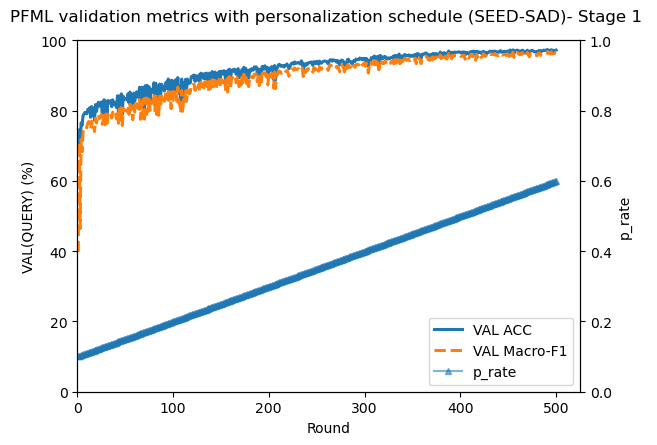

C:\Users\user00\AppData\Local\Temp\ipykernel_20016\2319730171.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.95])


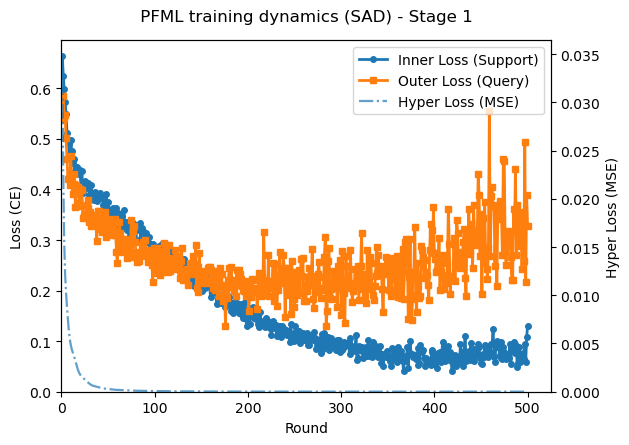

In [21]:
plot_pfml_history(trainer, save_dir="pfml_plots")

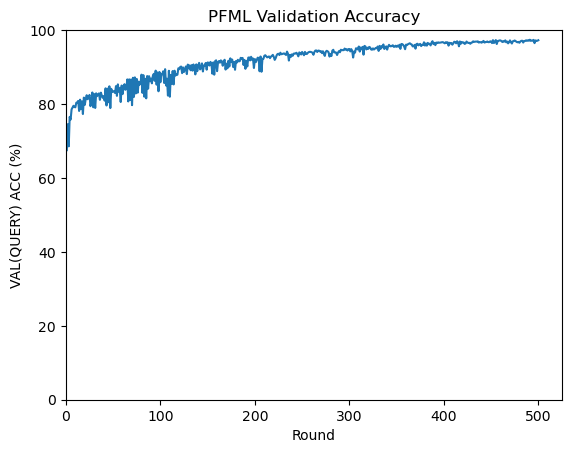

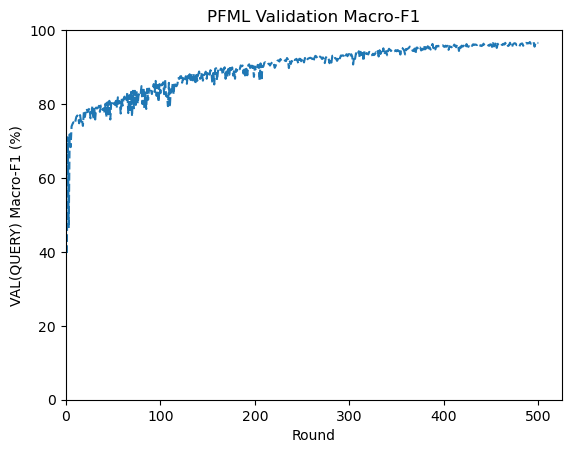

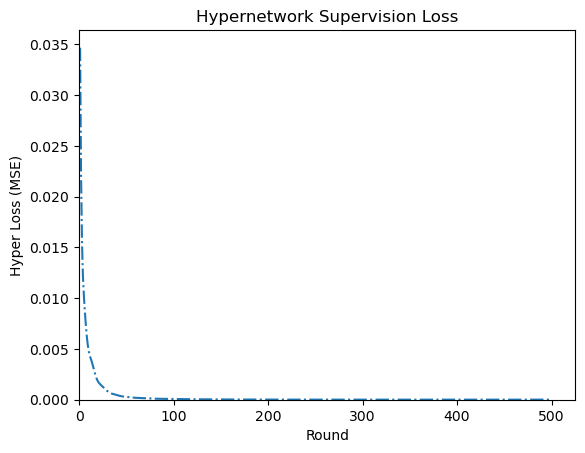

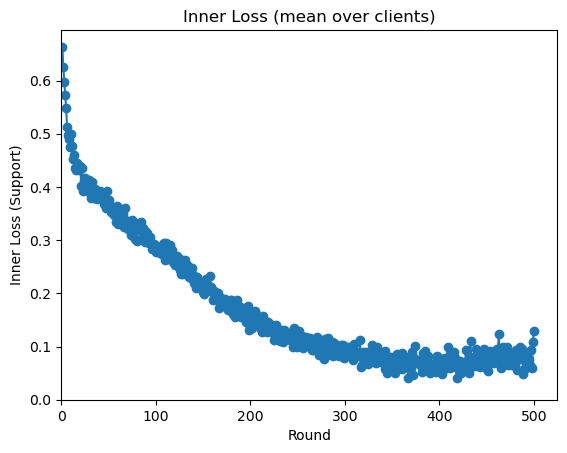

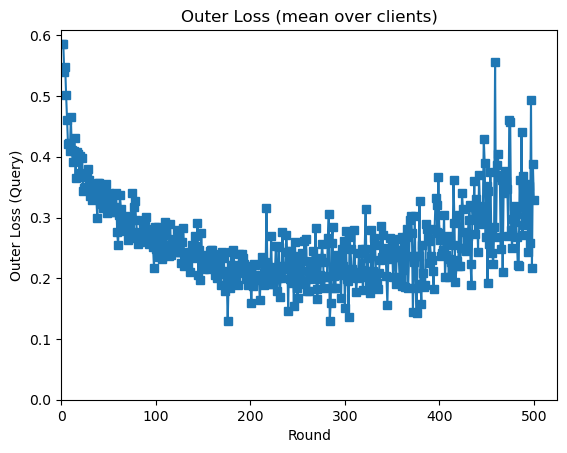

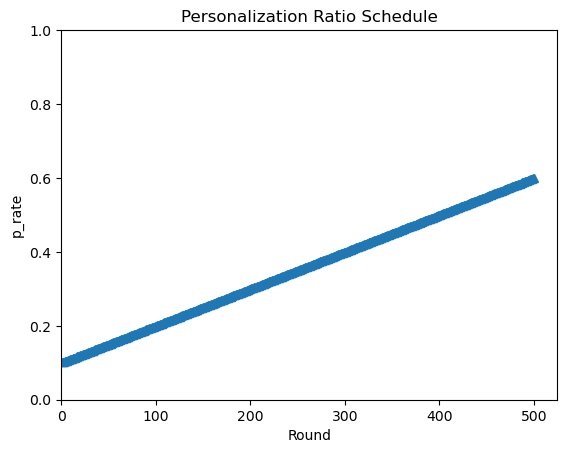

In [16]:
plot_pfml_history(trainer, save_dir="pfml_plots")

In [17]:

# -------- Final: load bestVAL + test ONCE --------
ckpt_g = "PFML_bestVAL_global.pth"
ckpt_h = "PFML_bestVAL_hypernet.pth"
ckpt_e = "PFML_bestVAL_embed.pth"

if os.path.exists(ckpt_g):
    trainer.global_model.load_state_dict(torch.load(ckpt_g, map_location=DEVICE), strict=True)
    print(f"[LOAD] {ckpt_g}")
else:
    print(f"[WARN] Missing checkpoint: {ckpt_g}")

if os.path.exists(ckpt_h):
    trainer.hypernet.load_state_dict(torch.load(ckpt_h, map_location=DEVICE), strict=True)
    print(f"[LOAD] {ckpt_h}")
else:
    print(f"[WARN] Missing checkpoint: {ckpt_h}")

if os.path.exists(ckpt_e):
    trainer.embed.load_state_dict(torch.load(ckpt_e, map_location=DEVICE), strict=True)
    print(f"[LOAD] {ckpt_e}")
else:
    print(f"[WARN] Missing checkpoint: {ckpt_e}")

# load best p_rate (so FINAL uses the exact p_rate of best round)
p_rate_final = P_RATE
if os.path.exists("PFML_bestVAL_meta.json"):
    import json
    with open("PFML_bestVAL_meta.json", "r") as f:
        meta = json.load(f)
    p_rate_final = float(meta.get("best_p_rate", P_RATE))
    print(f"[META] best_round={meta.get('best_round')} best_p_rate={p_rate_final}")
else:
    print("[WARN] Missing PFML_bestVAL_meta.json -> using default P_RATE")

per_sub, acc_stat, f1_stat, cm = eval_test_per_subject_pfml(
    trainer,
    p_rate=p_rate_final,
    save_txt=True,
    tag="FINAL_TEST",
    print_per_subject=True,
    print_cm_per_subject=False
)

acc_mean, acc_std = acc_stat
f1_mean, f1_std = f1_stat

print("\n========== FINAL (BEST-VAL CKPT) TEST SUMMARY ==========")
print(f"Mean ACC      : {acc_mean*100:.2f}% ± {acc_std*100:.2f}%")
print(f"Mean Macro-F1 : {f1_mean*100:.2f}% ± {f1_std*100:.2f}%")
print("Confusion Matrix (overall test):")
print(cm)
print("=======================================================")


C:\Users\user00\AppData\Local\Temp\ipykernel_20016\2843256396.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trainer.global_model.load_state_dict(torch.load(ckpt_g, map

[LOAD] PFML_bestVAL_global.pth
[LOAD] PFML_bestVAL_hypernet.pth
[LOAD] PFML_bestVAL_embed.pth
[META] best_round=491 best_p_rate=0.591

================ PFML FINAL_TEST (TEST) ================
Subjects used : 12
Mean ACC      : 95.00%  (Std 1.92%)
Mean Macro-F1 : 93.09%  (Std 2.81%)
Overall Confusion Matrix (all test samples):
[[1251   98]
 [ 141 2902]]

Per-subject results:
  cid |     N |   ACC   | Macro-F1
------|-------|---------|---------
    0 |   265 |  98.11% |   96.85%
    1 |   567 |  94.71% |   92.12%
    2 |   344 |  94.48% |   92.83%
    3 |   195 |  97.44% |   95.49%
    4 |   239 |  97.07% |   96.54%
    5 |   152 |  96.05% |   95.57%
    6 |   617 |  93.35% |   93.32%
    7 |   121 |  94.21% |   93.89%
    8 |   510 |  93.33% |   88.63%
    9 |   836 |  94.02% |   92.69%
   10 |   273 |  95.60% |   88.43%
   11 |   273 |  91.58% |   90.78%


========== FINAL (BEST-VAL CKPT) TEST SUMMARY ==========
Mean ACC      : 95.00% ± 1.92%
Mean Macro-F1 : 93.09% ± 2.81%
Confusion Ma